## Hyper-parameter

In [1]:
import sys
sys.path.append('..')
import utils
import mxnet as mx

num_epochs = 200
learning_rate = 0.3
weight_decay = 5e-4
lr_period = 30
lr_decay = 0.95
batch_size = 30
epoch_period = 10
theta = 0.1
ctx = utils.try_gpu()

In [2]:
clipping_norm = 0.1
eps = 20
delta = 1e-5

## Define Model

In [3]:
from mxnet import gluon
from mxnet import init
drop_prob1 = 0.1
drop_prob2 = 0.1
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(64, activation="relu"))
    net.add(gluon.nn.Dropout(drop_prob1))
    net.add(gluon.nn.Dense(32, activation="relu"))
    net.add(gluon.nn.Dropout(drop_prob2))
    net.add(gluon.nn.Dense(10))
net.initialize(ctx=ctx, init=init.Xavier())

## Loading data and define Loss and Trainer

In [4]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import image
import utils
import numpy as np


fmnist_root="~/.mxnet/datasets/fashion-mnist"
mnist_root = "~/.mxnet/datasets/mnist"

def easy_transform(data, label):
    return data.astype('float32')/255, label.astype('float32')

def transform_train(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                        rand_crop=False, rand_resize=False, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]), 
                        std=np.array([0.2023, 0.1994, 0.2010]), 
                        brightness=0, contrast=0, 
                        saturation=0, hue=0, 
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), 
                        mean=np.array([0.4914, 0.4822, 0.4465]), 
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def dataset_split(data, ratio):
    split_point = int(len(data) * ratio)
    data=data[:]
    X = data[0]
    y = nd.array(data[1])
    n = X.shape[0]
    idx = np.arange(n)
    np.random.shuffle(idx)
    X = nd.array(X.asnumpy()[idx])
    y = nd.array(y.asnumpy()[idx])
    X_train = X[:split_point]
    y_train = y[:split_point]
    X_valid = X[split_point:]
    y_valid = y[split_point:]
    train_dataset= gluon.data.ArrayDataset(X_train, y_train)
    test_dataset = gluon.data.ArrayDataset(X_valid, y_valid)
    return train_dataset, test_dataset

def evaluate_loss(loss_func, data_iterator, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    total_loss = 0.0
    if isinstance(data_iterator, mx.io.MXDataIter):
        data_iterator.reset()
    for data, label in data_iterator:
        cur_loss = softmax_cross_entropy(net(data), label).copyto(mx.cpu())
        total_loss += nd.mean(cur_loss).asscalar()
    return total_loss

validation_ratio = 0.3

mnist_train_valid = gluon.data.vision.MNIST(train=True, transform=easy_transform)
mnist_test = gluon.data.vision.MNIST(train=False, transform=easy_transform)
mnist_train, mnist_valid = dataset_split(mnist_train_valid, validation_ratio)

# cifar_train_valid = gluon.data.vision.CIFAR10(train=True, transform=easy_transform)
# cifar_test = gluon.data.vision.CIFAR10(train=False, transform=easy_transform)
# cifar_train, cifar_valid = dataset_split(cifar_train_valid, validation_ratio)

In [5]:
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(mnist_valid, batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(mnist_train_valid, batch_size, shuffle=True, last_batch='keep')

# 
# train_data = gluon.data.DataLoader(cifar_train, batch_size, shuffle=True, last_batch='keep')
# valid_data = gluon.data.DataLoader(cifar_valid, batch_size, shuffle=True, last_batch='keep')
# train_valid_data = gluon.data.DataLoader(mnist_train_valid, batch_size, shuffle=True, last_batch='keep')
# 

test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=False, last_batch='keep')
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## Training and testing

In [6]:
import datetime

def train(net, train_data, valid_data, epochs, lr, wd, lr_period, 
          lr_decay, epoch_period, ctx, clipping_norm, eps, delta, noise=False, Tuning=False):
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    if Tuning == False:
        net.collect_params().initialize(force_reinit=True)
    cur_train_loss = [evaluate_loss(softmax_cross_entropy,train_data, net, ctx) / len(train_data)]
    if valid_data is not None:
        cur_valid_loss = [evaluate_loss(softmax_cross_entropy,valid_data, net, ctx) / len(valid_data)]
    params = None
    print("start")
    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            lr *= lr_decay
        for data, label in train_data:
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data.as_in_context(ctx))
                loss = softmax_cross_entropy(output, label) 
            if params == None:
                params_notation = net.collect_params()
                params = []
                for key in params_notation.keys():
                    params.append(params_notation[key].data())  
            loss.backward()
            if noise == True:
                utils.Noisy_SGD(params, lr / batch_size , clipping_norm, eps, delta, ctx)
            else:
#                 trainer.step(batch_size) 
                utils.SGD(params, lr / batch_size)
                
            train_loss += nd.mean(loss).asscalar()
            train_acc += utils.accuracy(output, label)
        
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        cur_train_loss.append(train_loss / len(train_data))
        
        if valid_data != None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)   
            cur_valid_loss.append(evaluate_loss(softmax_cross_entropy,valid_data, net, ctx) / len(valid_data))
            epoch_str = ("Epoch %d. Loss: %f, Train acc %f, Valid acc %f, "
                            % (epoch, train_loss / len(train_data),
                            train_acc / len(train_data), valid_acc))
        else:
            epoch_str = ("Epoch %d. Loss: %f, Train acc %f "
                            % (epoch, train_loss / len(train_data), train_acc / len(train_data)))
        
        prev_time = cur_time
        if epoch % epoch_period == 0 or epoch == epochs - 1 or epoch == 1:
            print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))
                         
    if valid_data != None:
        return cur_train_loss, cur_valid_loss
    else:
        return cur_train_loss

In [7]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

start
Epoch 1. Loss: 2.297261, Train acc 0.200500, Valid acc 0.309048, Time 00:00:05, lr 0.3
Epoch 10. Loss: 1.583760, Train acc 0.548389, Valid acc 0.606333, Time 00:00:05, lr 0.3
Epoch 20. Loss: 0.986877, Train acc 0.687944, Valid acc 0.744071, Time 00:00:05, lr 0.3
Epoch 30. Loss: 0.836633, Train acc 0.733556, Valid acc 0.789214, Time 00:00:05, lr 0.285
Epoch 40. Loss: 0.741252, Train acc 0.770556, Valid acc 0.818643, Time 00:00:05, lr 0.285
Epoch 50. Loss: 0.663619, Train acc 0.795333, Valid acc 0.839024, Time 00:00:05, lr 0.285
Epoch 60. Loss: 0.611665, Train acc 0.815333, Valid acc 0.854119, Time 00:00:05, lr 0.27075
Epoch 70. Loss: 0.570244, Train acc 0.830944, Valid acc 0.864500, Time 00:00:05, lr 0.27075
Epoch 80. Loss: 0.536498, Train acc 0.841500, Valid acc 0.872738, Time 00:00:05, lr 0.27075
Epoch 90. Loss: 0.505913, Train acc 0.850333, Valid acc 0.878667, Time 00:00:05, lr 0.25721249999999996
Epoch 100. Loss: 0.486094, Train acc 0.859000, Valid acc 0.882881, Time 00:00:05,

Text(0.5,1,'Noise SGD eps = 50, delta = 1e-5')

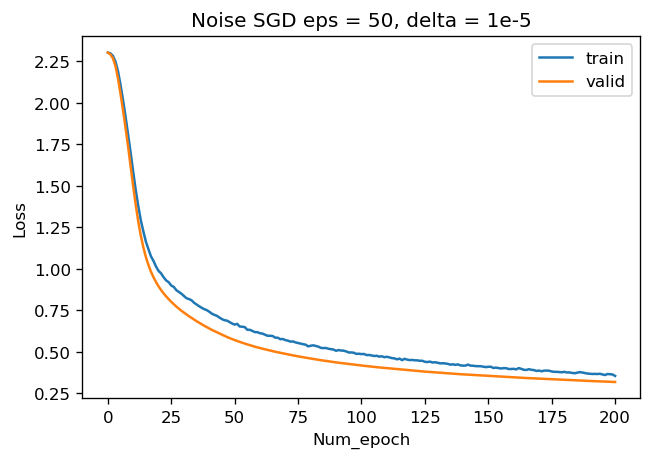

In [14]:
eps = 50
delta = 1e-5

train_loss, valid_loss = train(net, train_data, valid_data, num_epochs, 
                               learning_rate, weight_decay, lr_period, 
                               lr_decay, epoch_period, ctx, clipping_norm, eps, delta, noise=True)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('Noise SGD eps = 50, delta = 1e-5')

start
Epoch 1. Loss: 2.297943, Train acc 0.159722, Valid acc 0.247071, Time 00:00:05, lr 0.3
Epoch 10. Loss: 1.573524, Train acc 0.533778, Valid acc 0.591619, Time 00:00:05, lr 0.3
Epoch 20. Loss: 1.057171, Train acc 0.659833, Valid acc 0.726786, Time 00:00:05, lr 0.3
Epoch 30. Loss: 0.829897, Train acc 0.737833, Valid acc 0.795333, Time 00:00:05, lr 0.285
Epoch 40. Loss: 0.717887, Train acc 0.775444, Valid acc 0.823786, Time 00:03:06, lr 0.285
Epoch 50. Loss: 0.647584, Train acc 0.800722, Valid acc 0.840976, Time 00:00:05, lr 0.285
Epoch 60. Loss: 0.601391, Train acc 0.817722, Valid acc 0.853929, Time 00:00:05, lr 0.27075
Epoch 70. Loss: 0.564922, Train acc 0.828222, Valid acc 0.861976, Time 00:00:06, lr 0.27075
Epoch 80. Loss: 0.533905, Train acc 0.838222, Valid acc 0.869619, Time 00:00:05, lr 0.27075
Epoch 90. Loss: 0.509692, Train acc 0.846222, Valid acc 0.874976, Time 00:00:05, lr 0.25721249999999996
Epoch 100. Loss: 0.488818, Train acc 0.852667, Valid acc 0.878786, Time 00:00:05,

Text(0.5,1,'Noise SGD eps = 20, delta = 1e-5')

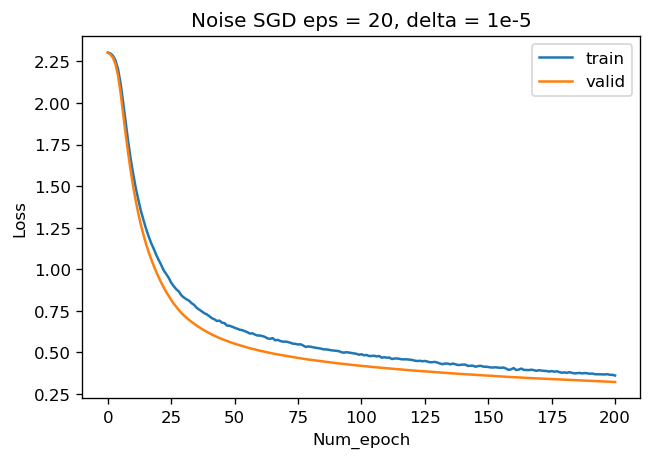

In [8]:
eps = 20
delta = 1e-5

train_loss, valid_loss = train(net, train_data, valid_data, num_epochs, 
                               learning_rate, weight_decay, lr_period, 
                               lr_decay, epoch_period, ctx, clipping_norm, eps, delta, noise=True)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('Noise SGD eps = 20, delta = 1e-5')

start
Epoch 1. Loss: 2.297684, Train acc 0.173222, Valid acc 0.294667, Time 00:00:05, lr 0.3
Epoch 10. Loss: 1.633649, Train acc 0.547556, Valid acc 0.625214, Time 00:00:06, lr 0.3
Epoch 20. Loss: 0.991010, Train acc 0.690833, Valid acc 0.767524, Time 00:00:06, lr 0.3
Epoch 30. Loss: 0.796118, Train acc 0.747611, Valid acc 0.808357, Time 00:00:07, lr 0.285
Epoch 40. Loss: 0.690814, Train acc 0.783111, Valid acc 0.835548, Time 00:00:05, lr 0.285
Epoch 50. Loss: 0.629493, Train acc 0.802556, Valid acc 0.850714, Time 00:00:05, lr 0.285
Epoch 60. Loss: 0.571298, Train acc 0.825833, Valid acc 0.864000, Time 00:00:08, lr 0.27075
Epoch 70. Loss: 0.531305, Train acc 0.837944, Valid acc 0.873905, Time 00:00:06, lr 0.27075
Epoch 80. Loss: 0.505718, Train acc 0.847000, Valid acc 0.880952, Time 00:08:50, lr 0.27075
Epoch 90. Loss: 0.473215, Train acc 0.858056, Valid acc 0.885810, Time 00:00:06, lr 0.25721249999999996
Epoch 100. Loss: 0.452624, Train acc 0.864056, Valid acc 0.889429, Time 00:00:05,

Text(0.5,1,'Noise SGD eps = 10, delta = 1e-5')

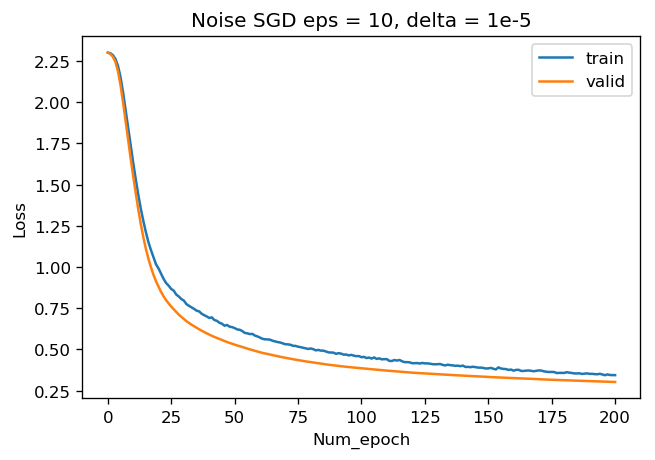

In [13]:
eps = 10
delta = 1e-5

train_loss, valid_loss = train(net, train_data, valid_data, num_epochs, 
                               learning_rate, weight_decay, lr_period, 
                               lr_decay, epoch_period, ctx, clipping_norm, eps, delta, noise=True)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('Noise SGD eps = 10, delta = 1e-5')

start
Epoch 1. Loss: 2.298297, Train acc 0.161611, Valid acc 0.223048, Time 00:00:05, lr 0.3
Epoch 10. Loss: 1.652548, Train acc 0.534833, Valid acc 0.621119, Time 00:00:06, lr 0.3
Epoch 20. Loss: 1.082996, Train acc 0.648722, Valid acc 0.729786, Time 00:00:06, lr 0.3
Epoch 30. Loss: 0.874541, Train acc 0.714944, Valid acc 0.787357, Time 00:00:06, lr 0.285
Epoch 40. Loss: 0.778513, Train acc 0.752056, Valid acc 0.816452, Time 00:00:05, lr 0.285
Epoch 50. Loss: 0.703960, Train acc 0.770778, Valid acc 0.839143, Time 00:00:05, lr 0.285
Epoch 60. Loss: 0.667188, Train acc 0.782278, Valid acc 0.845714, Time 00:00:05, lr 0.27075
Epoch 70. Loss: 0.643747, Train acc 0.791500, Valid acc 0.853833, Time 00:00:06, lr 0.27075
Epoch 80. Loss: 0.615747, Train acc 0.806111, Valid acc 0.859452, Time 00:00:05, lr 0.27075
Epoch 90. Loss: 0.596290, Train acc 0.810000, Valid acc 0.865214, Time 00:00:05, lr 0.25721249999999996
Epoch 100. Loss: 0.567980, Train acc 0.820667, Valid acc 0.869905, Time 00:00:06,

Text(0.5,1,'Noise SGD eps = 4, delta = 1e-5')

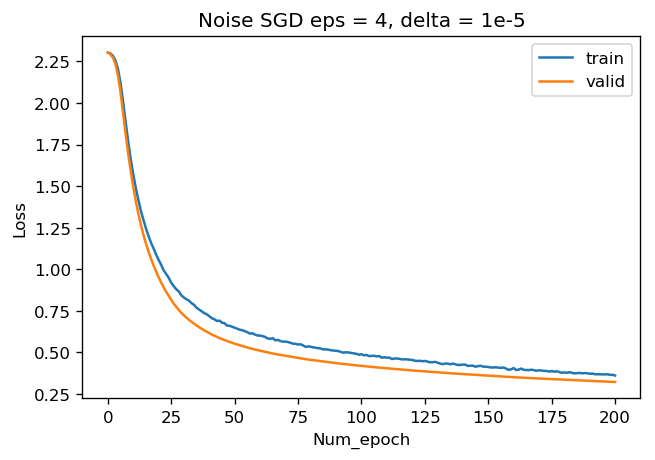

In [9]:
eps = 4
delta = 1e-5

train_loss_1, valid_loss_2 = train(net, train_data, valid_data, num_epochs, 
                               learning_rate, weight_decay, lr_period, 
                               lr_decay, epoch_period, ctx, clipping_norm, eps, delta, noise=True)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('Noise SGD eps = 4, delta = 1e-5')

start
Epoch 1. Loss: 2.294949, Train acc 0.199500, Valid acc 0.269190, Time 00:00:05, lr 0.3
Epoch 10. Loss: 1.538157, Train acc 0.509333, Valid acc 0.580095, Time 00:00:06, lr 0.3
Epoch 20. Loss: 1.113794, Train acc 0.626833, Valid acc 0.727119, Time 00:00:06, lr 0.3
Epoch 30. Loss: 1.020364, Train acc 0.649222, Valid acc 0.754357, Time 00:00:05, lr 0.285
Epoch 40. Loss: 0.949633, Train acc 0.678889, Valid acc 0.768238, Time 00:00:06, lr 0.285
Epoch 50. Loss: 0.908514, Train acc 0.692944, Valid acc 0.781381, Time 00:00:06, lr 0.285
Epoch 60. Loss: 0.919459, Train acc 0.690167, Valid acc 0.782095, Time 00:00:05, lr 0.27075
Epoch 70. Loss: 0.890435, Train acc 0.710333, Valid acc 0.789452, Time 00:00:06, lr 0.27075
Epoch 80. Loss: 0.899207, Train acc 0.705056, Valid acc 0.795881, Time 00:00:06, lr 0.27075
Epoch 90. Loss: 0.879688, Train acc 0.719444, Valid acc 0.805024, Time 00:00:06, lr 0.25721249999999996
Epoch 100. Loss: 0.913590, Train acc 0.709333, Valid acc 0.797762, Time 00:00:06,

Text(0.5,1,'Noise SGD eps = 3, delta = 1e-5')

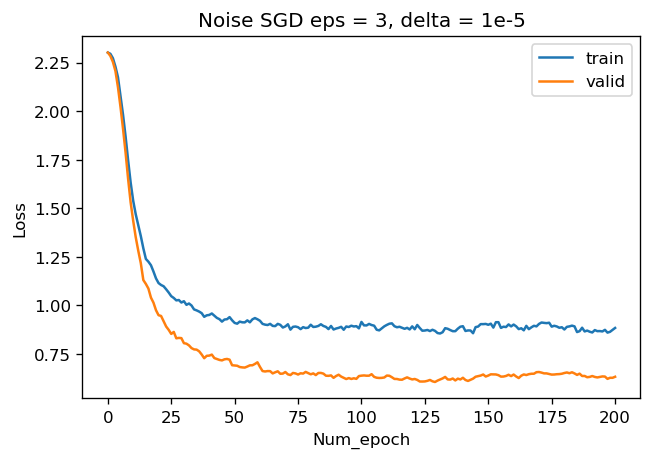

In [10]:
eps = 3
delta = 1e-5

train_loss, valid_loss = train(net, train_data, valid_data, num_epochs, 
                               learning_rate, weight_decay, lr_period, 
                               lr_decay, epoch_period, ctx, clipping_norm, eps, delta, noise=True)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('Noise SGD eps = 3, delta = 1e-5')

start
Epoch 1. Loss: 2.298856, Train acc 0.112278, Valid acc 0.162405, Time 00:00:05, lr 0.3
Epoch 10. Loss: 1.949922, Train acc 0.314778, Valid acc 0.410000, Time 00:00:06, lr 0.3
Epoch 20. Loss: 1.867634, Train acc 0.406500, Valid acc 0.488143, Time 00:00:06, lr 0.3
Epoch 30. Loss: 2.259421, Train acc 0.387278, Valid acc 0.456071, Time 00:00:06, lr 0.285
Epoch 40. Loss: 2.545616, Train acc 0.347278, Valid acc 0.409738, Time 00:00:06, lr 0.285
Epoch 50. Loss: 2.389107, Train acc 0.340944, Valid acc 0.417119, Time 00:00:07, lr 0.285
Epoch 60. Loss: 2.283492, Train acc 0.324444, Valid acc 0.371405, Time 00:00:06, lr 0.27075
Epoch 70. Loss: 2.247904, Train acc 0.357556, Valid acc 0.406714, Time 00:00:06, lr 0.27075
Epoch 80. Loss: 2.190041, Train acc 0.346056, Valid acc 0.370167, Time 00:00:06, lr 0.27075
Epoch 90. Loss: 2.410164, Train acc 0.337500, Valid acc 0.360548, Time 00:00:06, lr 0.25721249999999996
Epoch 100. Loss: 2.421140, Train acc 0.270056, Valid acc 0.293333, Time 00:00:06,

Text(0.5,1,'Noise SGD eps = 2, delta = 1e-5')

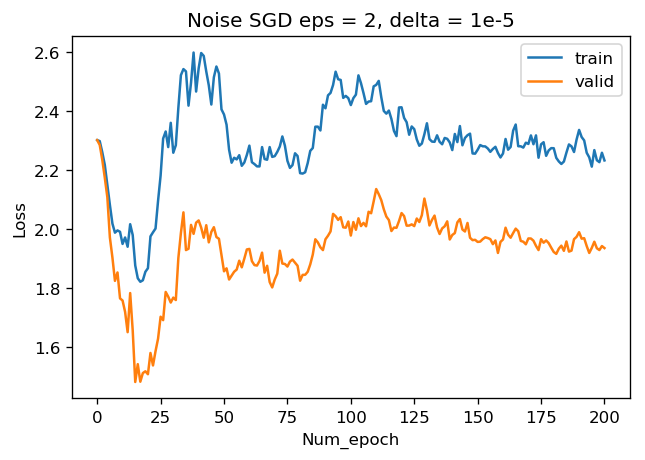

In [11]:
eps = 2
delta = 1e-5

train_loss, valid_loss = train(net, train_data, valid_data, num_epochs, 
                               learning_rate, weight_decay, lr_period, 
                               lr_decay, epoch_period, ctx, clipping_norm, eps, delta, noise=True)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','valid'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('Noise SGD eps = 2, delta = 1e-5')

start
Epoch 1. Loss: 0.712881, Train acc 0.764444, Valid acc 0.921452, Time 00:00:03, lr 0.3
Epoch 10. Loss: 0.100536, Train acc 0.969778, Valid acc 0.947952, Time 00:00:04, lr 0.3
Epoch 20. Loss: 0.068274, Train acc 0.978111, Valid acc 0.963524, Time 00:00:06, lr 0.3
Epoch 30. Loss: 0.050150, Train acc 0.984056, Valid acc 0.961786, Time 00:00:04, lr 0.285
Epoch 40. Loss: 0.048396, Train acc 0.985056, Valid acc 0.962190, Time 00:00:04, lr 0.285
Epoch 50. Loss: 0.036439, Train acc 0.988389, Valid acc 0.963357, Time 00:00:04, lr 0.285
Epoch 60. Loss: 0.031643, Train acc 0.989667, Valid acc 0.963000, Time 00:00:04, lr 0.27075
Epoch 70. Loss: 0.035091, Train acc 0.990111, Valid acc 0.963405, Time 00:00:04, lr 0.27075
Epoch 80. Loss: 0.030972, Train acc 0.990389, Valid acc 0.962476, Time 00:00:04, lr 0.27075
Epoch 90. Loss: 0.027964, Train acc 0.991889, Valid acc 0.962357, Time 00:00:04, lr 0.25721249999999996
Epoch 100. Loss: 0.021902, Train acc 0.993611, Valid acc 0.964452, Time 00:00:04,

Text(0.5,1,'Normal SGD')

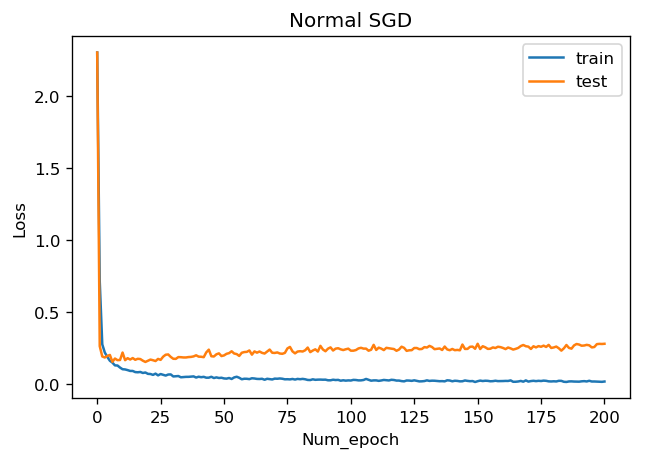

In [12]:
train_loss, valid_loss = train(net, train_data, valid_data, num_epochs, 
                               learning_rate, weight_decay, lr_period, 
                               lr_decay, epoch_period, ctx, clipping_norm, eps, delta, noise=False)

plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train','test'])
plt.xlabel('Num_epoch')
plt.ylabel('Loss')
plt.title('Normal SGD')